# Spatial spread

author: steeve.laquitaine@epfl.ch

**purpose**: calculate units' spatial spread.

**Method**: 
1. get average spike on nearest site (max template)
2. get average spike of all other sites (template)
3. calculate cosine similarities between these templates and weight by site distance to get footprint score

Reference:

- “We defined the spatial extent of the waveform as the spatial scale across channels over which the waveform shape is maintained” 
- We calculated a similarity weight as the cosine similarity between nearest site's average spike and other sites' average spikes 
- We used it to weight all site distances to the nearest site: The same site distances are weighted more if similarity is higher producing higher spatial spread.

inspired from ([Pachitariu et al., 2023, p. 22](zotero://select/groups/4861315/items/M23PP7CZ)) ([pdf](zotero://open-pdf/groups/4861315/items/8WTMLPJD?page=22&annotation=WUITX5F2))

In [217]:
%load_ext autoreload
%autoreload 2
import os
import spikeinterface as si
import pandas as pd 
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
import warnings
import spikeinterface.postprocessing as spost

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)

from src.nodes.postpro import waveform
from src.nodes.utils import get_config
from src.nodes.metrics.spike import get_spatial_spread_all_units, get_spatial_spread

data_conf, _ = get_config("silico_neuropixels", "2023_10_18").values()
STUDY_FOLDER = data_conf["postprocessing"]["waveform"]["ground_truth"]["study"]
REC_FOLDER = data_conf["preprocessing"]["output"]["trace_file_path"]


MS_BEFORE = 3
MS_AFTER = 3


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-01-29 19:21:53,795 - root - utils.py - get_config - INFO - Reading experiment config.
2024-01-29 19:21:53,810 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [182]:
def euclidean_distance(coord_1, coord_2):
    return np.sqrt(np.sum((coord_1 - coord_2) ** 2))


# def get_spatial_spread(
#     WvfExtractor, unit_id: int, max_chids: dict, channel_ids, channel_coord
# ):
#     """measure unit's spatial spread

#     Args:
#         unit_id (int): _description_
#         max_chids (dict): _description_
#         Recording (_type_): _description_
#         channel_ids (_type_): _description_
#         channel_coord (_type_): _description_

#     Returns:
#         _type_: _description_
#     """
#     MAX_DISTANCE = 200  # theoretically isolatable

#     # get site templates
#     templates = WvfExtractor.get_template(unit_id, mode="average")

#     # get this unit's max site
#     max_site = max_chids[unit_id]
#     max_temp = templates[:, max_site]

#     # measure each site's template's similarity to the max site's template
#     # (ratio between 0 and 1)
#     n_sites = templates.shape[1]
#     cosim_weights = []
#     for s_i in range(n_sites):
#         cosim_weights.append(
#             np.dot(max_temp, templates[:, s_i])
#             / (norm(max_temp) * norm(templates[:, s_i]))
#         )
#     cosim_weights = np.array(cosim_weights)

#     # threshold similarity to be positive
#     # we only look at similarity (not inverse similarity (<0))
#     cosim_weights[cosim_weights < 0] = 0

#     # measure site distances
#     max_chids_coord = channel_coord[np.where(channel_ids == max_site)[0][0], :]
#     chid_distances = []
#     for chid in channel_ids:
#         chid_coord = channel_coord[np.where(channel_ids == chid)[0][0], :]
#         chid_distances.append(euclidean_distance(max_chids_coord, chid_coord))
#     chid_distances = np.array(chid_distances)
#     loc_max_distances_to_keep = np.where(chid_distances < MAX_DISTANCE)[0]

#     # remove distance beyond 200 ums (Buzsaki, Einevoll, to get rid of spurious similarities coming
#     # from other unit spikes on other channels)
#     cosim_weights = cosim_weights[loc_max_distances_to_keep]
#     chid_distances = chid_distances[loc_max_distances_to_keep]

#     # return spatial spread
#     return {
#         "spatial_spread": np.dot(cosim_weights, chid_distances),
#         "channel_distance": chid_distances,
#         "weights": cosim_weights,
#     }


# def get_spatial_spread_all_units(
#     recording_path: str, study_path: str, ms_before: float, ms_after: float
# ):
#     # takes 1:30 min

#     # get Waveform extractor
#     Recording = si.load_extractor(recording_path)
#     WvfExtractor = waveform.load(
#         Recording, study_path, ms_before=ms_before, ms_after=ms_after
#     )
#     # get unit ids
#     unit_ids = WvfExtractor.unit_ids

#     # get each site's distance to the max site
#     Recording = si.load_extractor(REC_FOLDER)
#     channel_ids = Recording.get_channel_ids()
#     channel_coord = Recording.get_channel_locations()

#     # get channels where spike amplitude is maximal
#     max_chids = spost.get_template_extremum_channel(WvfExtractor, peak_sign="both")

#     # takes 1:30 min (1310 units)
#     spatial_spread = dict()
#     for ix, unit_id in enumerate(unit_ids):
#         spatial_spread[unit_id] = get_spatial_spread(
#             WvfExtractor, unit_id, max_chids, channel_ids, channel_coord
#         )["spatial_spread"]
#     return spatial_spread

### Compute spatial spread

In [183]:
# takes 1:40 min (1310 units)
spatial_spread = get_spatial_spread_all_units(
    REC_FOLDER, STUDY_FOLDER, MS_BEFORE, MS_AFTER
)

42.279581136550725
4852.491750125613


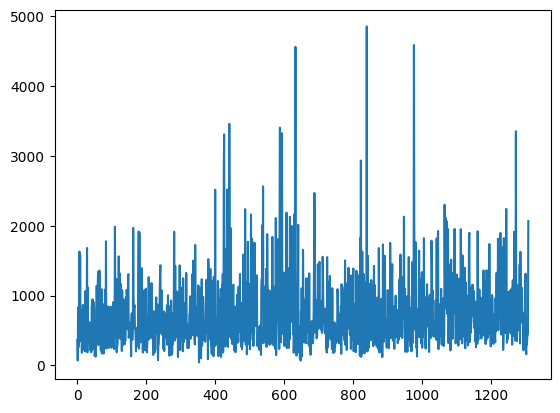

In [210]:
# plot
plt.plot(spatial_spread.values())
print(np.min(list(spatial_spread.values())))
print(np.max(list(spatial_spread.values())))

### Plot example units

In [211]:
# get Waveform extractor
Recording = si.load_extractor(REC_FOLDER)
WvfExtractor = waveform.load(
    Recording, STUDY_FOLDER, ms_before=MS_BEFORE, ms_after=MS_AFTER
)
# get unit ids
unit_ids = WvfExtractor.unit_ids

# get each site's distance to the max site
Recording = si.load_extractor(REC_FOLDER)
channel_ids = Recording.get_channel_ids()
channel_coord = Recording.get_channel_locations()

# get channels where spike amplitude is maximal
max_chids = spost.get_template_extremum_channel(WvfExtractor, peak_sign="both")

spatial extent: 364.6765860956066
spatial extent: 71.04213008781822
spatial extent: 829.9198338764783


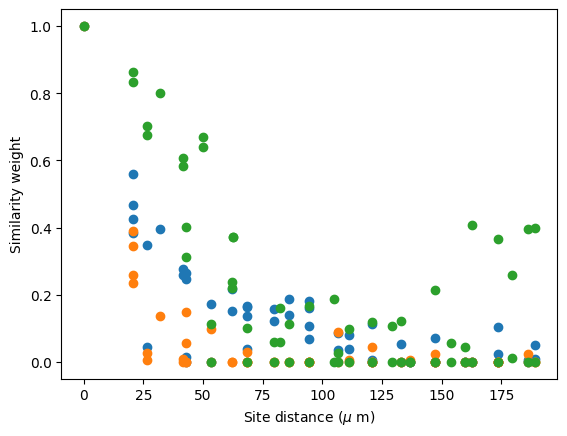

In [215]:
# plot similarity weights for increasing distance
# for three example units
for _, ix in enumerate([0, 1, 2]):
    out = get_spatial_spread(
        WvfExtractor, unit_ids[ix], max_chids, channel_ids, channel_coord
    )
    df = pd.DataFrame(data=out["channel_distance"], columns=["channel_distance"])
    df["weights"] = out["weights"]
    df_sorted = df.sort_values(by=["channel_distance"])
    plt.plot(
        df_sorted["channel_distance"],
        df_sorted["weights"],
        "o",
        label=f"unit {unit_ids[ix]}",
    )
    plt.xlabel("Site distance ($\mu$ m)")
    plt.ylabel("Similarity weight")
    print("spatial extent:", out["spatial_spread"])

In [ ]:
dd